In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import save_image
sns.set_theme()
torch.set_default_dtype(torch.float32)

In [2]:
class Encoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma



class Decoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        return torch.sigmoid(self.network(x))

class VAE_torch(nn.Module):
    def __init__(self,encoder, decoder,latent_size,device="cpu"):
        super().__init__()
        self.latent_size=latent_size
        self.encoder=encoder.to(device)
        self.decoder=decoder.to(device)
        self.device=device
    
    def forward(self,x):
        mu,sigma=self.encoder(x)
        eps=torch.normal(0,1,(mu.shape[0],self.latent_size),device=self.device)
        sampled_vector=mu+eps*sigma
        return self.decoder(sampled_vector),mu,sigma

    def sample(self,x):
        mu,sigma=self.encoder(x)
        sampled_vector=torch.zeros(x.shape[0],self.latent_size,device=self.device)
        for j in range(mu.shape[0]):
            sampled_vector[j,:]=torch.distributions.Normal(mu[j],sigma[j]).sample()
        print(sampled_vector,sampled_vector.device)
        return self.decoder(sampled_vector)


def KL(mean,sigma):
    return 0.5*torch.sum((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma.pow(2)),dim=1)-1))

def ELBO(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.binary_cross_entropy(pred_values, values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def ELBO_MSE(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.mse_loss(pred_values,values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def visualize(res1,VAE):
    new=VAE.sample(res1.expand(5,784))
    f,axes=plt.subplots(2,3,figsize=(21,14))
    ax=axes.flatten()[0]
    ax.imshow(res1.cpu().numpy().reshape(28,28),cmap="viridis_r")
    ax.set_title("Original image")
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(4)
    for j in range(5):
        ax=axes.flatten()[j+1]
        ax.imshow(new[j,:].detach().cpu().numpy().reshape(28,28),cmap="viridis_r")
    plt.tight_layout()


def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))

def generate(VAE,n,name="images.png"):
    input=torch.normal(0,1,[n*n,VAE.latent_size])
    output=VAE.decoder(input.to(VAE.device))
    save_image(output.reshape(n*n,1,28,28),name)

In [3]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()

In [4]:
num_epoch=40
batch=100
use_gpu=True
if use_gpu:
    VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10,"cuda")
    device = torch.device("cuda")
    xtrain=xtrain.to(device)
    xtest=xtest.to(device)
else:
    VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE(xbatch)
        loss=ELBO(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE(xtest)
        loss_test=ELBO(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 173.682 loss test: 163.437
Epoche:  1 loss train: 145.958 loss test: 147.170
Epoche:  2 loss train: 141.432 loss test: 143.462
Epoche:  3 loss train: 138.324 loss test: 140.313
Epoche:  4 loss train: 135.566 loss test: 137.398
Epoche:  5 loss train: 133.903 loss test: 138.006
Epoche:  6 loss train: 132.993 loss test: 137.006
Epoche:  7 loss train: 132.297 loss test: 135.536
Epoche:  8 loss train: 130.982 loss test: 135.445
Epoche:  9 loss train: 131.492 loss test: 135.427
Epoche:  10 loss train: 130.187 loss test: 134.780
Epoche:  11 loss train: 130.535 loss test: 134.110
Epoche:  12 loss train: 132.006 loss test: 133.840
Epoche:  13 loss train: 129.638 loss test: 133.944
Epoche:  14 loss train: 128.920 loss test: 134.172
Epoche:  15 loss train: 129.460 loss test: 132.959
Epoche:  16 loss train: 128.958 loss test: 133.850
Epoche:  17 loss train: 129.579 loss test: 132.994
Epoche:  18 loss train: 130.562 loss test: 132.404
Epoche:  19 loss train: 129.210 loss test

Text(0.5, 0, 'epoche number')

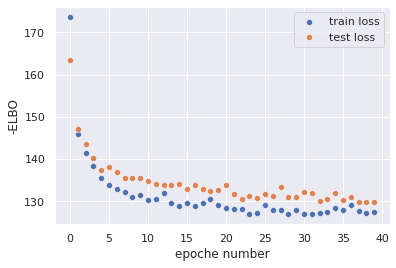

In [5]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-0.9267, -0.7962, -0.9291,  1.4014,  0.3335,  0.2894, -1.8977,  0.7762,
         -0.2862, -0.6866],
        [-0.6131, -1.5432, -0.9463,  1.6582, -1.0789, -1.1772, -0.0706, -0.1277,
         -0.3339, -0.5502],
        [-0.6384,  1.0028, -0.9427,  1.4883,  0.1546,  1.1973,  0.0816, -0.4958,
         -0.4050, -0.6090],
        [-0.5124,  1.4450, -1.0580,  1.4286,  2.0694, -1.3557, -0.3169, -0.2695,
         -0.4387, -0.6413],
        [-0.4931,  0.9457, -1.0030,  1.4204, -1.3250,  0.2502, -0.4527,  1.1591,
         -0.2504, -0.6556]], device='cuda:0') cuda:0


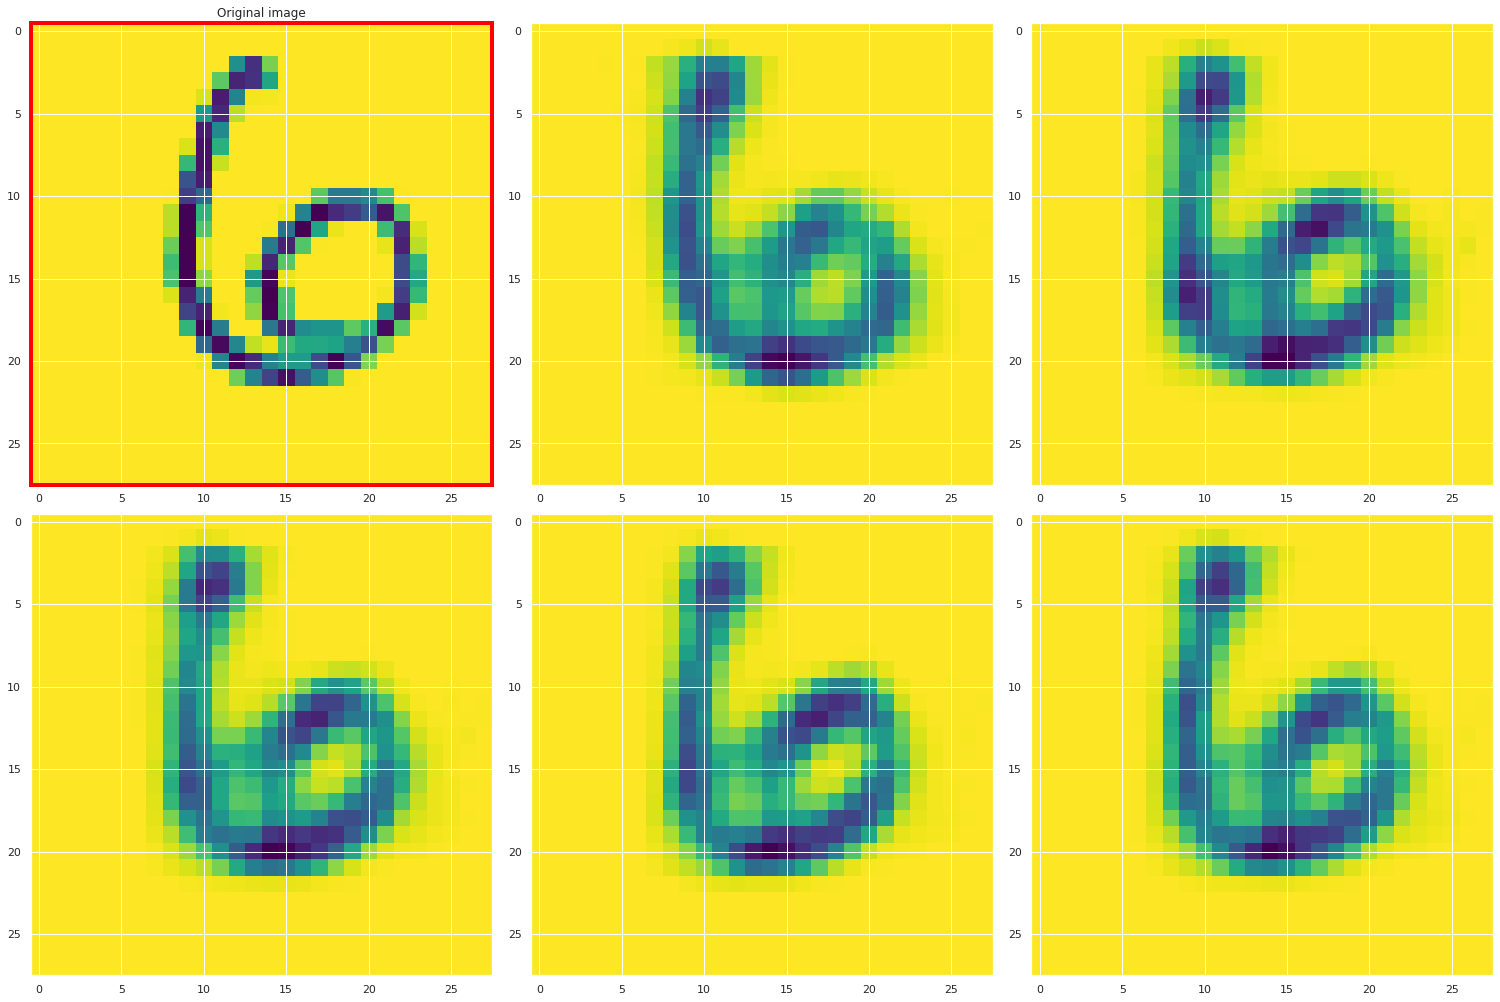

In [6]:
n=100
visualize(xtest[n],VAE)

In [7]:
num_epoch=40    
batch=100
if use_gpu:
    VAE_MSE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10,"cuda")
    device = torch.device("cuda" if use_gpu else "cpu")
    xtrain=xtrain.to(device)
    xtest=xtest.to(device)
else:
    VAE_MSE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE_MSE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE_MSE(xbatch)
        loss=ELBO_MSE(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE_MSE(xtest)
        loss_test=ELBO_MSE(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 53.707 loss test: 50.874
Epoche:  1 loss train: 46.891 loss test: 44.673
Epoche:  2 loss train: 43.949 loss test: 42.575
Epoche:  3 loss train: 40.456 loss test: 41.046
Epoche:  4 loss train: 38.848 loss test: 40.225
Epoche:  5 loss train: 38.362 loss test: 39.492
Epoche:  6 loss train: 37.504 loss test: 39.001
Epoche:  7 loss train: 37.539 loss test: 38.907
Epoche:  8 loss train: 37.710 loss test: 38.649
Epoche:  9 loss train: 37.120 loss test: 38.387
Epoche:  10 loss train: 37.640 loss test: 38.703
Epoche:  11 loss train: 36.478 loss test: 38.275
Epoche:  12 loss train: 36.530 loss test: 38.328
Epoche:  13 loss train: 36.402 loss test: 38.058
Epoche:  14 loss train: 36.434 loss test: 38.098
Epoche:  15 loss train: 36.553 loss test: 37.792
Epoche:  16 loss train: 36.665 loss test: 37.804
Epoche:  17 loss train: 36.470 loss test: 37.903
Epoche:  18 loss train: 36.196 loss test: 37.760
Epoche:  19 loss train: 36.652 loss test: 37.738
Epoche:  20 loss train: 36.496

Text(0.5, 0, 'epoche number')

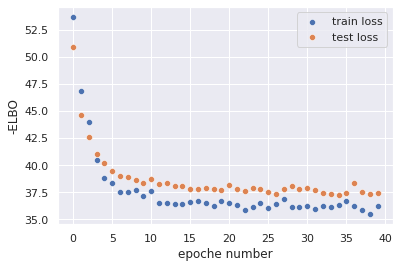

In [8]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-0.8430, -0.5673,  0.6652,  1.0089,  0.6730,  0.3039,  0.2140,  0.5114,
         -0.1002, -0.4882],
        [ 0.9850, -0.7793, -0.0072,  0.7804,  1.0695, -0.9839,  0.6159, -0.0728,
         -0.6295, -0.3086],
        [-0.5974, -0.7455, -1.5724,  0.7788,  0.9039, -0.5078,  0.2891,  1.0328,
          0.1672,  0.3267],
        [ 0.6616, -0.8000,  1.2776,  0.9538,  0.5739,  0.8969,  0.3545,  0.7048,
         -0.8264,  0.0236],
        [-1.5358, -0.6765,  1.2751,  1.1361,  0.4413,  0.8470,  0.1506,  1.4000,
         -0.1217, -0.4324]], device='cuda:0') cuda:0


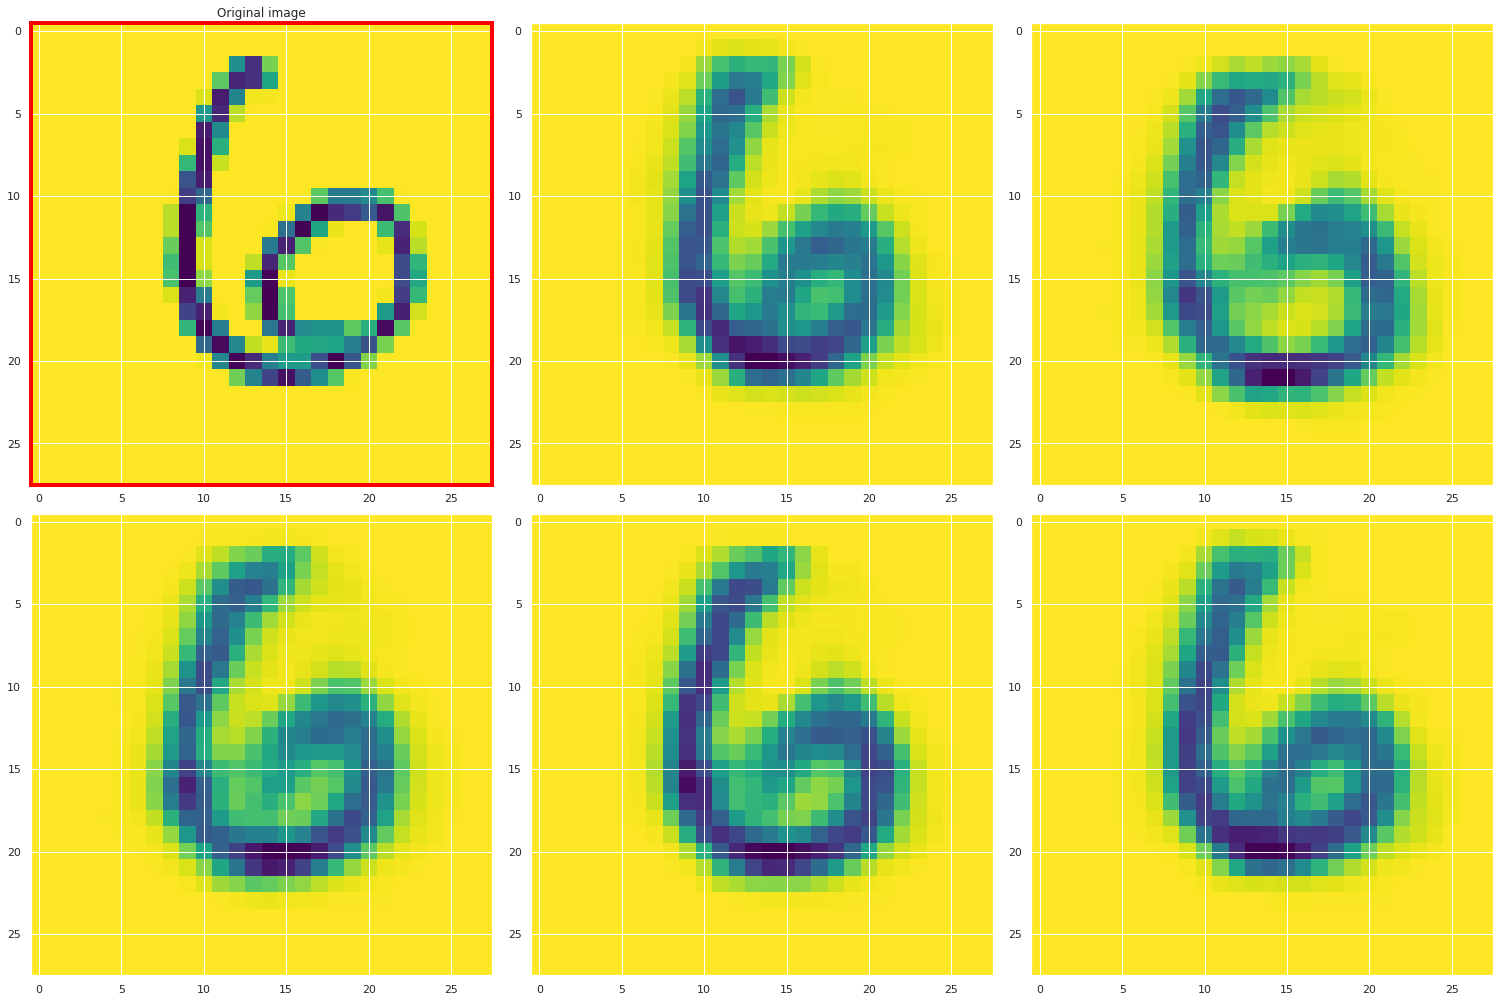

In [9]:
n=100
visualize(xtest[n],VAE_MSE)

In [10]:
generate(VAE,8,"cross_entropy.png")
generate(VAE_MSE,8,"MSE.png")